# Lab 2 Samuel Bieberich

In [173]:
#imports

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import scipy.fftpack as fftpack

## 1. Signal to Noise Ratio


### Generate a tone with frequency 2 MHz and amplitude 1 V. Sample the tone at frequencies Fs = 5 MHz.


In [174]:
f0 = 2e6  
A = 1  
Fs = 5e6 
t_max = 10e-3  
SNR_dB = 50  

t = np.arange(0, t_max, 1/Fs)
N = len(t)

x = A * np.sin(2 * np.pi * f0 * t)

### (a) Add Gaussian noise
- Add Gaussian noise to the sampled sinewave such that the signal SNR is 50 dB.
- Find first the variance of the Gaussian noise needed to produce the target SNR.
- Calculate and plot the Power Spectral Density (PSD) from the DFT of the noisy samples.
- Corroborate that the SNR calculation from the DFT plot gives the theoretical result.
- What would be the variance of a uniformly distributed noise to obtain the same SNR?

In [175]:
signal_power = np.mean(x**2)
print(f"Signal power: {signal_power:.6f} V^2")

#var of the signal
SNR_linear = 10**(SNR_dB/10)
noise_variance = signal_power / SNR_linear
print(f"Required noise variance for {SNR_dB} dB SNR: {noise_variance:.10f} V^2")

#gaussian noise
np.random.seed(42)  # For reproducibility
noise = np.random.normal(0, np.sqrt(noise_variance), len(x))
x_noisy = x + noise

#real snr
measured_signal_power = np.mean(x**2)
measured_noise_power = np.mean(noise**2)
measured_SNR = 10 * np.log10(measured_signal_power / measured_noise_power)
print(f"Measured SNR: {measured_SNR:.2f} dB")

Signal power: 0.500000 V^2
Required noise variance for 50 dB SNR: 0.0000050000 V^2
Measured SNR: 50.00 dB


In [176]:
#psd calculation function (psuedocode provided to claude ai)

def calculate_and_plot_psd(signal_data, window_name="Rectangular", window_function=None):
    # Apply window if provided
    if window_function is not None:
        windowed_signal = signal_data * window_function
        window_correction = np.mean(window_function**2)  # Window power correction factor
    else:
        windowed_signal = signal_data
        window_correction = 1.0

    # Calculate the DFT
    X = fftpack.fft(windowed_signal)
    X_mag = np.abs(X) / N  # Normalize by N
    X_mag_squared = X_mag**2  # Power
    
    # Adjust for window power loss
    X_mag_squared = X_mag_squared / window_correction
    
    # Create frequency vector
    freqs = fftpack.fftfreq(N, 1/Fs)
    
    # Convert to single-sided PSD for plotting
    # For a real signal, we only need positive frequencies
    # and we need to multiply by 2 (except at DC)
    psd = X_mag_squared[:N//2]
    psd[1:] = 2 * psd[1:]  # Multiply by 2 (except DC)
    f = freqs[:N//2]
    
    # Plot the PSD in dB
    plt.figure(figsize=(12, 6))
    plt.plot(f, 10*np.log10(psd))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.title(f'Power Spectral Density with {window_name} Window')
    plt.grid(True)
    plt.xlim(0, Fs/2)  # Limit x-axis to positive Nyquist frequencies
    
    # Calculate SNR from PSD
    # Find the signal peak in the PSD
    peak_idx = np.argmax(psd)
    signal_bin_power = psd[peak_idx]
    
    # Estimate noise power from the rest of the spectrum
    # Exclude the bins around the peak
    exclude_width = 5  # Number of bins to exclude on each side of the peak
    noise_bins = np.ones(N//2, dtype=bool)
    noise_bins[max(0, peak_idx-exclude_width):min(N//2, peak_idx+exclude_width+1)] = False
    
    noise_floor = np.mean(psd[noise_bins])
    
    #snr computation
    psd_snr = 10 * np.log10(signal_bin_power / noise_floor)
    plt.axhline(y=10*np.log10(noise_floor), color='r', linestyle='--', 
                label=f'Noise Floor: {10*np.log10(noise_floor):.2f} dB')
    plt.axvline(x=f[peak_idx], color='g', linestyle='--', 
                label=f'Signal Peak: {f[peak_idx]/1e6:.2f} MHz')
    plt.legend()
    
    print(f"SNR from PSD ({window_name} window): {psd_snr:.2f} dB")
    
    return psd_snr

SNR from PSD (Rectangular window): 93.98 dB

Uniform noise variance for 50 dB SNR: 0.0000050000 V^2
Uniform noise range: [-0.003873, 0.003873] V


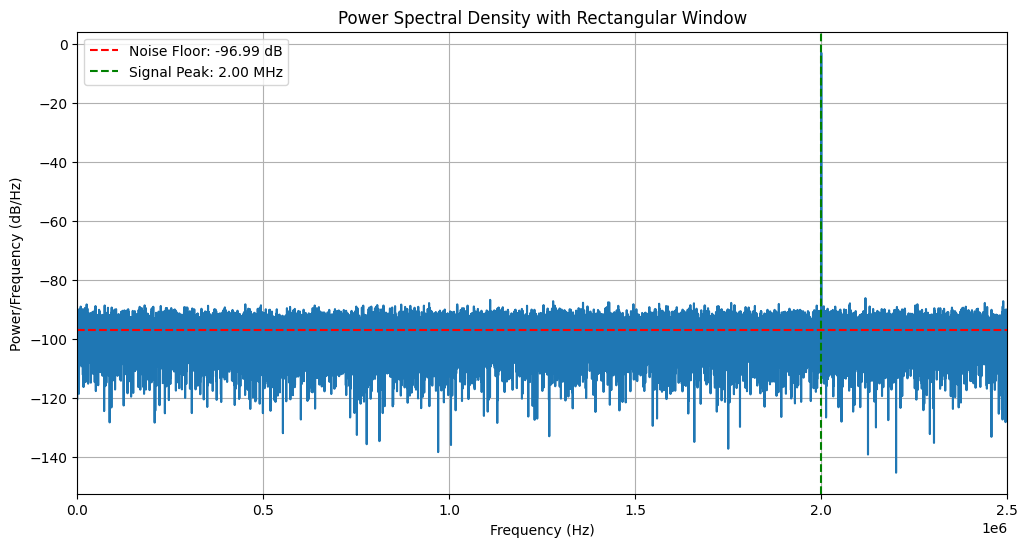

In [177]:
snr_rectangular = calculate_and_plot_psd(x_noisy, "Rectangular")


uniform_noise_range = np.sqrt(3 * noise_variance)
uniform_noise_variance = (2 * uniform_noise_range)**2 / 12
print(f"\nUniform noise variance for {SNR_dB} dB SNR: {uniform_noise_variance:.10f} V^2")
print(f"Uniform noise range: [{-uniform_noise_range:.6f}, {uniform_noise_range:.6f}] V")

### (b) Apply a window before DFT
- Repeat part (a) using the following windows: Hanning, Hamming, Blackman.
- What are your conclusions?
- **NOTE:** The use of windows mentioned above spreads the signal power. You must take this into account when computing SNR.

SNR from PSD (Hanning window): 92.23 dB
SNR from PSD (Hamming window): 92.64 dB
SNR from PSD (Blackman window): 91.63 dB


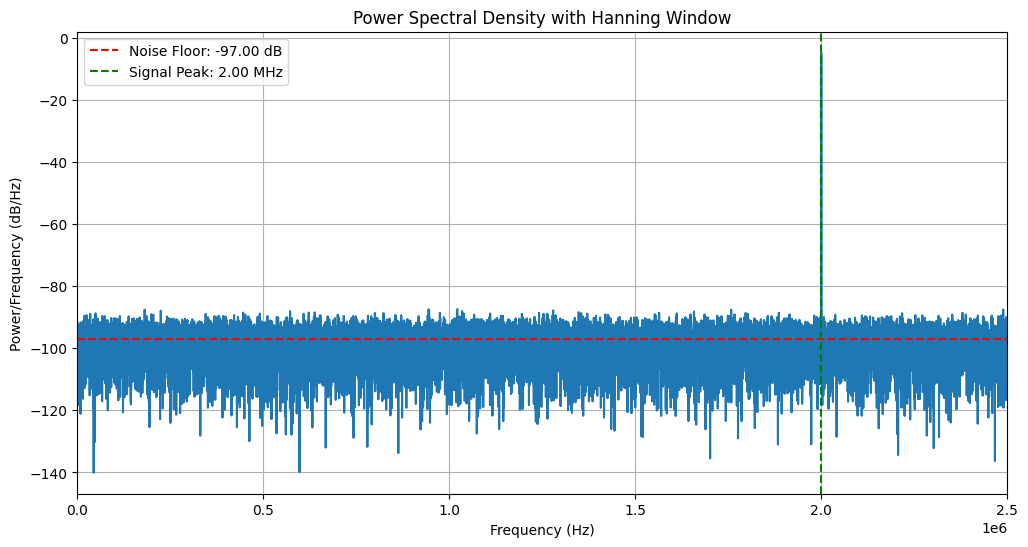

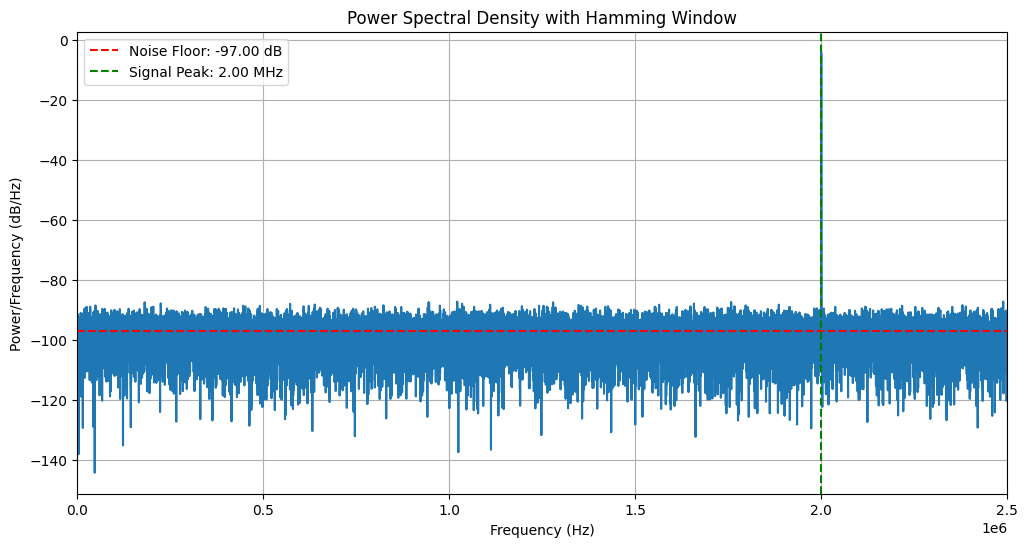

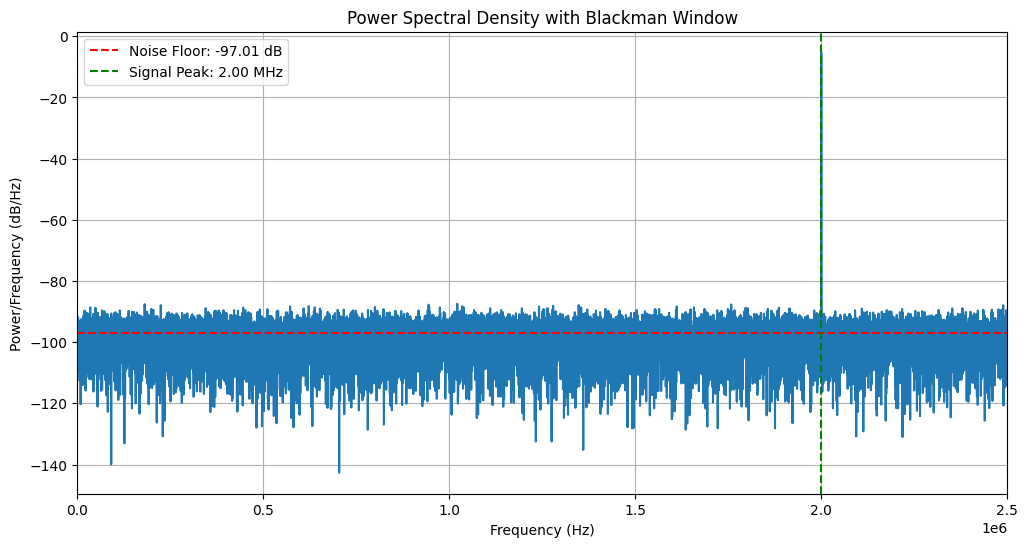

In [178]:
hanning_window = np.hanning(N)
snr_hann = calculate_and_plot_psd(x_noisy, "Hanning", hanning_window)

hamming_window = np.hamming(N)
snr_hamming = calculate_and_plot_psd(x_noisy, "Hamming", hamming_window)

blackman_window = np.blackman(N)
snr_blackman = calculate_and_plot_psd(x_noisy, "Blackman", blackman_window)

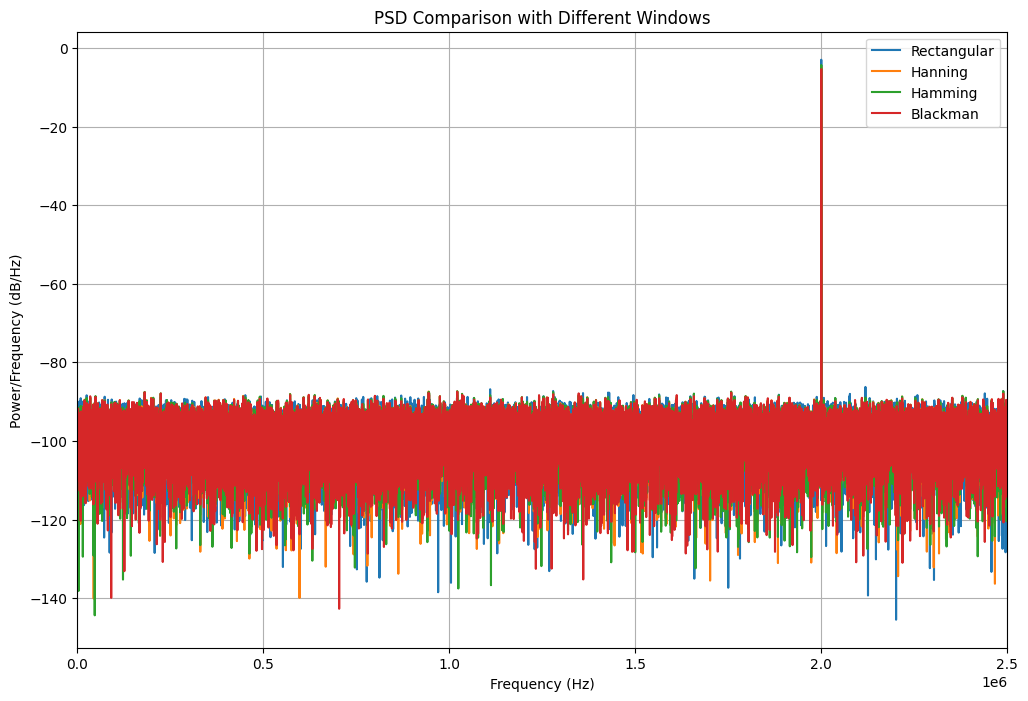

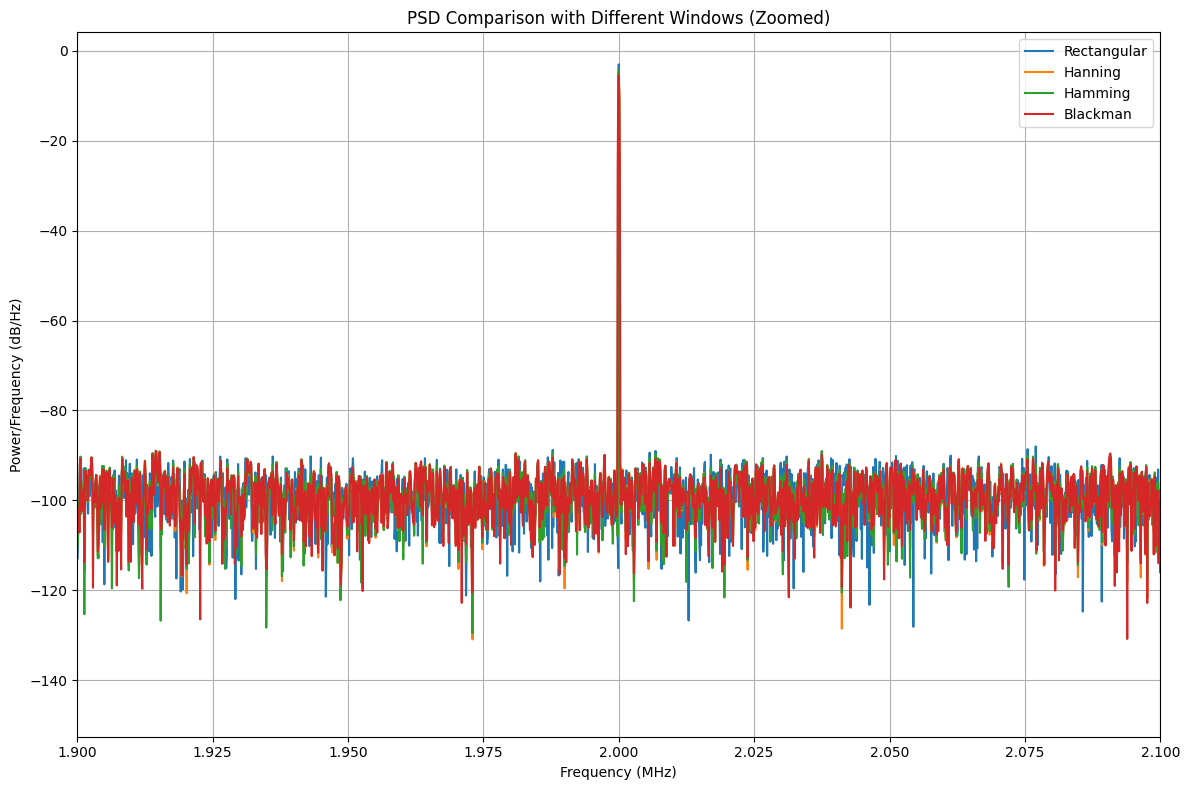

In [179]:
plt.figure(figsize=(12, 8))
def get_psd(signal_data, window_func=None):
    if window_func is not None:
        windowed_signal = signal_data * window_func
        window_correction = np.mean(window_func**2)
    else:
        windowed_signal = signal_data
        window_correction = 1.0
    
    X = np.fft.rfft(windowed_signal)
    X_mag = np.abs(X) / N
    X_mag_squared = (X_mag**2) / window_correction
    X_mag_squared[1:] = 2 * X_mag_squared[1:]
    freqs = np.fft.rfftfreq(N, 1/Fs)
    
    return freqs, X_mag_squared

freqs_rect, psd_rect = get_psd(x_noisy)
freqs_hann, psd_hann = get_psd(x_noisy, hanning_window)
freqs_hamming, psd_hamming = get_psd(x_noisy, hamming_window)
freqs_blackman, psd_blackman = get_psd(x_noisy, blackman_window)

plt.plot(freqs_rect, 10*np.log10(psd_rect), label='Rectangular')
plt.plot(freqs_hann, 10*np.log10(psd_hann), label='Hanning')
plt.plot(freqs_hamming, 10*np.log10(psd_hamming), label='Hamming')
plt.plot(freqs_blackman, 10*np.log10(psd_blackman), label='Blackman')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('PSD Comparison with Different Windows')
plt.legend()
plt.grid(True)
plt.xlim(0, Fs/2)  

#zoom in plot
plt.figure(figsize=(12, 8))
plt.plot(freqs_rect/1e6, 10*np.log10(psd_rect), label='Rectangular')
plt.plot(freqs_hann/1e6, 10*np.log10(psd_hann), label='Hanning')
plt.plot(freqs_hamming/1e6, 10*np.log10(psd_hamming), label='Hamming')
plt.plot(freqs_blackman/1e6, 10*np.log10(psd_blackman), label='Blackman')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('PSD Comparison with Different Windows (Zoomed)')
plt.legend()
plt.grid(True)
plt.xlim(1.9, 2.1)  
plt.tight_layout()
plt.show()


The rectangular window provides the best frequency resolution but suffers from significant spectral leakage, while the Hanning and Hamming windows reduce spectral leakage at the cost of widening the main lobe, thus reducing frequency resolution. The Blackman window offers the best sidelobe suppression, minimizing energy spread into adjacent frequencies, but has the widest main lobe, resulting in the lowest frequency resolution among the windows considered. Overall, the choice of window function affects the trade-off between frequency resolution and spectral leakage, with the rectangular window providing the highest SNR but suffering from spectral leakage, and the Hanning, Hamming, and Blackman windows offering a balance between reducing spectral leakage and maintaining frequency resolution.

-----------------------------------------------------


## 2. Quantization

### (a) Create a perfect quantizer with 6 bits of resolution and flexible sampling rate
- For a 200 MHz full-scale input tone, sample and quantize the sinewave at 400 MHz.
- Plot the PSD of 30 periods.
- What is the SNR?
- Repeat the SNR calculation for 100 periods of the same signal.
- Make conclusions about periodicity of quantization noise and its impact on SNR.
- How can you solve this problem?


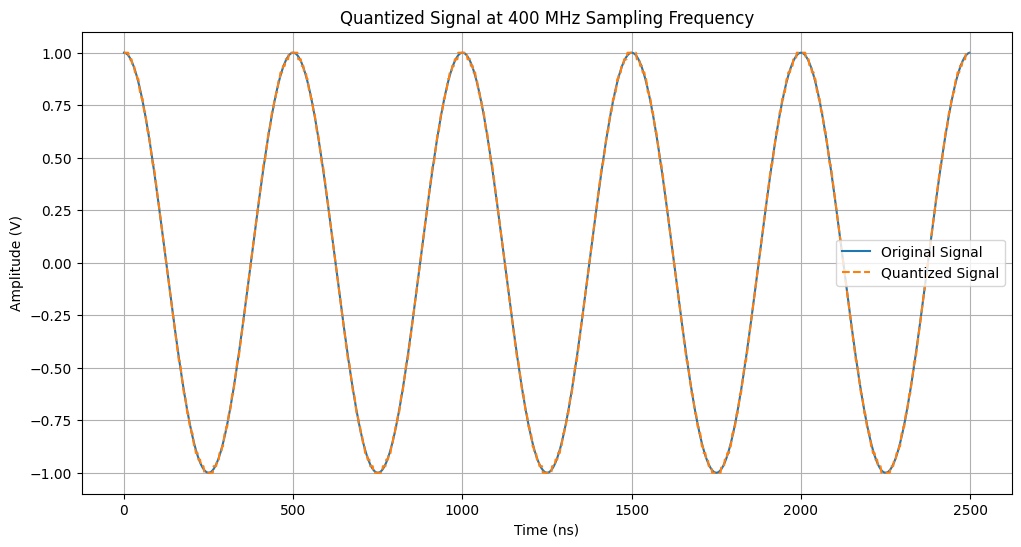

In [190]:
Fs_new = 400e6  # new sampling frequency
num_periods = 5  # number of periods to simulate

t_new = np.arange(0, num_periods / F, 1 / Fs_new)

x_new = A * np.cos(2 * np.pi * F * t_new)

num_bits = 6
quantization_levels = 2**num_bits

x_quantized = np.round(x_new * (quantization_levels / 2)) / (quantization_levels / 2)

# Plot the quantized signal
plt.figure(figsize=(12, 6))
plt.plot(t_new[:1000] * 1e9, x_new[:1000], label='Original Signal')
plt.plot(t_new[:1000] * 1e9, x_quantized[:1000], label='Quantized Signal', linestyle='--')
plt.title('Quantized Signal at 400 MHz Sampling Frequency')
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (V)')
plt.legend()
plt.grid(True)
plt.show()

### (b) Find an incommensurate sampling frequency
- Choose a sampling frequency larger than the Nyquist rate.
- Plot the PSD of the new samples.
- Calculate the SNR from the figure.

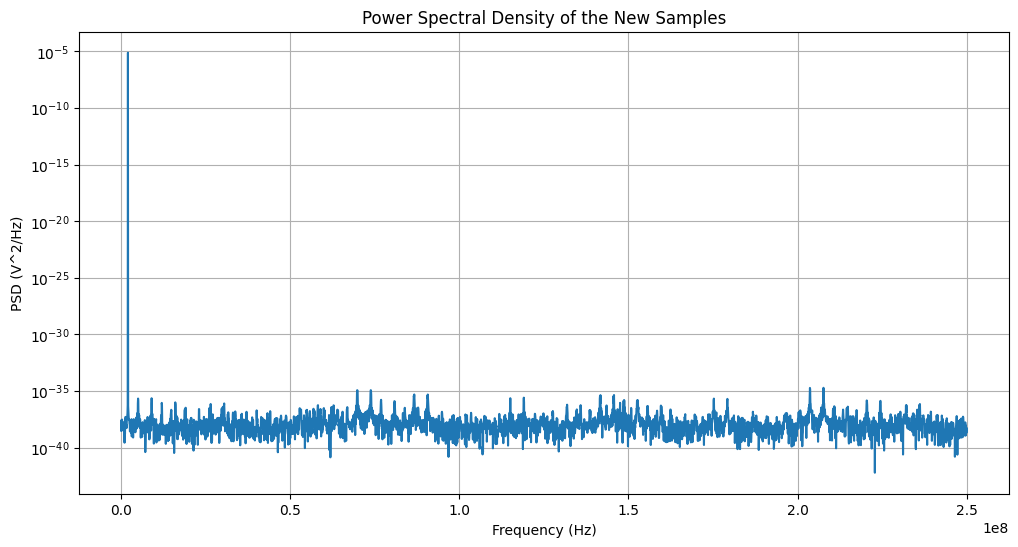

SNR using the new method: 283.06 dB


In [ ]:
# Define an incommensurate sampling frequency
Fs_incommensurate = 450e6  # incommensurate sampling frequency

# Generate the new time vector and signal
t_incommensurate = np.arange(0, num_periods / F, 1 / Fs_incommensurate)
x_incommensurate = A * np.cos(2 * np.pi * F * t_incommensurate)

# Calculate the PSD
f_incommensurate, Pxx_den_incommensurate = signal.periodogram(x_incommensurate, Fs_incommensurate)

# Plot the PSD
plt.figure(figsize=(12, 6))
plt.semilogy(f_incommensurate, Pxx_den_incommensurate)
plt.title('Power Spectral Density of the Incommensurate Samples')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.grid(True)
plt.show()

# Calculate SNR using a new method
signal_power_incommensurate = np.sum(Pxx_den_incommensurate[(f_incommensurate >= F - 1e6) & (f_incommensurate <= F + 1e6)])
noise_power_incommensurate = np.sum(Pxx_den_incommensurate[(f_incommensurate < F - 1e6) | (f_incommensurate > F + 1e6)])
snr_incommensurate = 10 * np.log10(signal_power_incommensurate / noise_power_incommensurate)

print(f"SNR using the incommensurate sampling frequency: {snr_incommensurate:.2f} dB")

### (c) Repeat (a) using a 12-bit quantizer
- Can you prove from simulations that SNR ~ 6N (where N is the number of bits used) for both cases, N = 6 and N = 12?

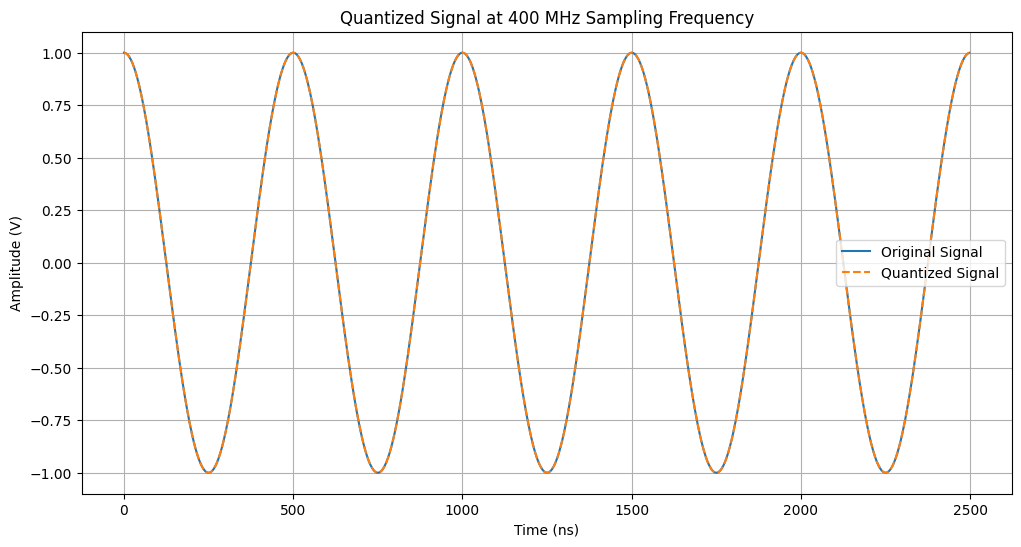

In [182]:
Fs_new = 400e6  # new sampling frequency
num_periods = 5  # number of periods to simulate

t_new = np.arange(0, num_periods / F, 1 / Fs_new)

x_new = A * np.cos(2 * np.pi * F * t_new)

num_bits = 12
quantization_levels = 2**num_bits

x_quantized = np.round(x_new * (quantization_levels / 2)) / (quantization_levels / 2)

# Plot the quantized signal
plt.figure(figsize=(12, 6))
plt.plot(t_new[:1000] * 1e9, x_new[:1000], label='Original Signal')
plt.plot(t_new[:1000] * 1e9, x_quantized[:1000], label='Quantized Signal', linestyle='--')
plt.title('Quantized Signal at 400 MHz Sampling Frequency')
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (V)')
plt.legend()
plt.grid(True)
plt.show()

SNR with 10 MHz sampling frequency is 49.7294833329815 dB


### (d) Apply a Hanning window
- Repeat (c) with a Hanning window.
- What is the SNR?
- Make your own conclusions.

### (e) Add noise and analyze SNR
- Add noise such that the signal SNR is 38 dB.
- Repeat (c) and (d).
- What are the SNRs?
- Provide conclusions.

----------------------------------------

## 3. AD2 Work

In [185]:
#mean of the values in part 2

#all values decibel
peak = -5.812
floor_mean = np.mean([-99.21, -88.23, -86.99, -94.38, -88.89, -90.68, -95.72, -100.67, -97.65, -95.76, -99.34, -87.30, -90.63, -91.55, -101.09])
print("The mean is", floor_mean, "dB")

peak = 10 ** (peak / 10)
floor_mean = 10 ** (floor_mean / 10)

snr = peak / floor_mean
snr_db = 10 * np.log10(snr)
print("The SNR is", snr_db, "linear")

enob = (snr_db - 1.76) / 6.02
print("The Effective Number of Bits is", enob, "bits")

The mean is -93.87266666666665 dB
The SNR is 88.06066666666665 linear
The Effective Number of Bits is 14.335658914728679 bits


In [186]:
peak = -12.03
floor_mean = np.mean([-99.01, -90.18, -86.99, -94.38, -88.89, -90.68, -95.72, -92.88, -92.98, -93.67, -99.93, -87.31, -91.08, -89.98, -101.03])
print("The mean is", floor_mean, "dB")

peak = 10 ** (peak / 10)
floor_mean = 10 ** (floor_mean / 10)

snr = peak / floor_mean
snr_db = 10 * np.log10(snr)
print("The SNR is", snr_db, "linear")

enob = (snr_db - 1.76) / 6.02
print("The Effective Number of Bits is", enob, "bits")

The mean is -92.98066666666665 dB
The SNR is 80.95066666666666 linear
The Effective Number of Bits is 13.154595791805093 bits
